<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AMAZON FINE FOOD REVIEWS : LOGISTIC REGRESSION

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


**DATA SET SPLITS ** 

1. AVG_WORD2VEC : 70K TRAIN,  30K TEST
2. TFIDF_WORD2VEC : 70K TRAIN ,  30K TEST
3. BOW : 60K TRAIN,  20K CV,  20K TEST
4. TFIDF : 60K TRAIN, 20K CV,  20K TEST

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,roc_auc_score,precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import vstack
import operator
import wordcloud
from scipy.stats import norm, uniform

** MOUNTING FROM GOOGLE DRIVE ** 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## FEATURIZATION ONE : BAG OF WORDS 

** IMPORTING THE DATA**

In [0]:
bow_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_bow.sav','rb'))
bow_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_bow.sav','rb'))
bow_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_bow.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
bow = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/BOW.sav','rb'))

** CONCATENATING TRAIN AND CV  TO CREATE DATASET FOR CROSS VALIDATION** 

In [0]:
X_train = vstack([bow_train,bow_cv])

In [0]:
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

In [0]:
X_train

<80000x29133 sparse matrix of type '<class 'numpy.float64'>'
	with 2424650 stored elements in Compressed Sparse Row format>

In [0]:
len(Y_train)

80000

In [0]:
#standard Scaling with respect to X_train (bow_train + bow_cv)
sc = StandardScaler(with_mean = False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(bow_test)

** GRID SEARCH FOR FINDING THE BEST C (1/Lambda ) : L2 Regualarisation **

1. Finding Best C value for L2 Regularisation 
2. C Range : $10^{-5}$  to $10^{9}$
3. Metric : Weighted F1 Score : Taking into considereation both the recall and precision of the negative classes.
4. CV = 3 
 


In [0]:
c_vals = []
for i in range(-5,10,1):
  c_vals.append(10**i)

In [0]:
param_grid = {'C':c_vals}

clf = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,Y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=True)

In [0]:
clf.best_score_

0.914867457708628

In [0]:
clf.best_params_

{'C': 0.001}

-----
** MODEL EVALUATION : **

1. Comparison of other metrics
2. Observing overfitting and underfitting phenomenon : Train and Test error
3. Feature importance of the best model

** C : 0.001 ** 

In [0]:
l1 = LogisticRegression(C = 0.001,n_jobs = -1)
l1.fit(X_train,Y_train)
pred = l1.predict(X_test)
t_pred = l1.predict(X_train)
print(classification_report(pred,y_test))
print("\n")
print("Test Error : " + str((1 - accuracy_score(pred,y_test))*100))
print("Train Error : " + str((1 - accuracy_score(t_pred,Y_train))*100))

             precision    recall  f1-score   support

          0       0.57      0.77      0.66      1995
          1       0.97      0.94      0.95     18005

avg / total       0.93      0.92      0.92     20000



Test Error : 8.015000000000006
Train Error : 2.893749999999995


** OBSERVATIONS **

| C | ACCURACY   | RECALL : NEGATIVE REVIEWS |TRAIN ERROR | TEST ERROR | DIFFERENCE|
|------|------|-----|-----|----|----|
|   0.001 | 92.0% | 77 |2.8917|8.015|5.125|




------
** FEATURE IMPORTANCE  : L2 Regularisation ** 

In [0]:
features = bow.get_feature_names()

In [0]:
f_imp = dict(zip(bow.vocabulary_,l1.coef_[0]))

In [0]:
p_r = {}
n_r = {}
for i in list(f_imp.keys()):
  if f_imp[i] <0:
    n_r[i] = f_imp[i]
  else:
    p_r[i] = f_imp[i]

** POSITIVE REVIEWS ** 

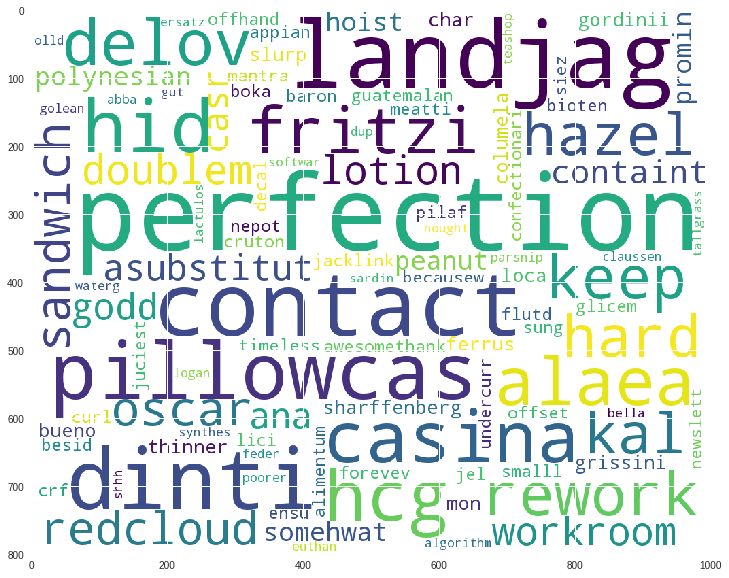

In [0]:
p_100 = {}
for i in sorted(p_r.items(), key=operator.itemgetter(1),reverse= True)[:100]:
  p_100[i[0]] = i[1]
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(p_100))

** Negative Reviews ** 

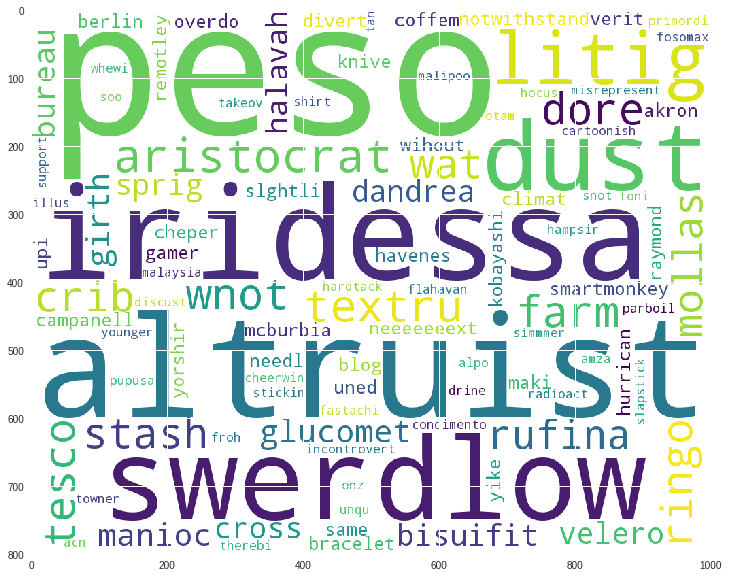

In [0]:
n_100 = {}
for i in sorted(n_r.items(), key=operator.itemgetter(1),reverse= False)[:100]:
  n_100[i[0]] = i[1] * (-1) #getting the abosulte value to bring out the most prominent words which impact the classifier more. 
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(n_100))

<br>

------

** L1 Regularisation ** 

1. Understanding sparsity by increasing the value of C  for BOW representation in using Training data.
2. Getting f1 weighted scoring using L1 Regularizer. 
3. Getting the feature names whose importance is zero. 

In [0]:
#standarad scaling with respect to bow_train
sc1 = StandardScaler(with_mean = False)
bow_train = sc1.fit_transform(bow_train)
bow_cv = sc1.transform(bow_cv)
bow_test = sc1.transform(bow_test)

In [0]:
c_vals = []
for i in range(-5,1,1):
  c_vals.append(10**i)
  
cv_no_zeros= {} 
cv_r = {}

#for getting the values 

#loop
for i in c_vals:
  l1_r = LogisticRegression(penalty = 'l1',C = i,n_jobs = -1)
  print("Training for l1 regualriser and C : "  + str(i) + "\n")
  l1_r. fit(bow_train,y_train)
  cv_no_zeros[i] = (len(l1_r.coef_[0]) - np.count_nonzero(l1_r.coef_)) #appending the number of zeroes 
  #predicting the class
  cv_pred = l1_r.predict(bow_cv)
  cv_r[i] = recall_score(cv_pred,y_cv,average = 'binary',pos_label= 0)

Training for l1 regualriser and C : 1e-05

Training for l1 regualriser and C : 0.0001

Training for l1 regualriser and C : 0.001

Training for l1 regualriser and C : 0.01

Training for l1 regualriser and C : 0.1

Training for l1 regualriser and C : 1



** RECALL SCORE  : NEGATIVE REVIEWS PLOT ** 

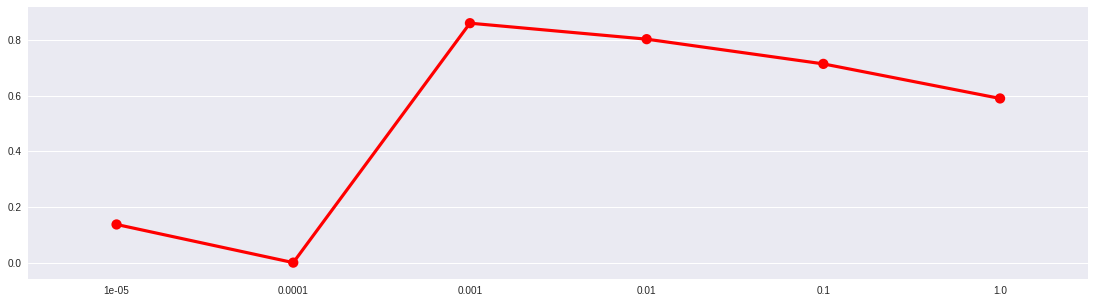

In [0]:
plt.figure(figsize = (19,5))
sns.pointplot(x = list(cv_r.keys()),y=list(cv_r.values()),color ='red')

In [0]:
max(cv_r.items(), key=operator.itemgetter(1))

(0.001, 0.8599221789883269)

** SPARSITY : NUMBER OF ZEROS IN WEIGHTS ** 

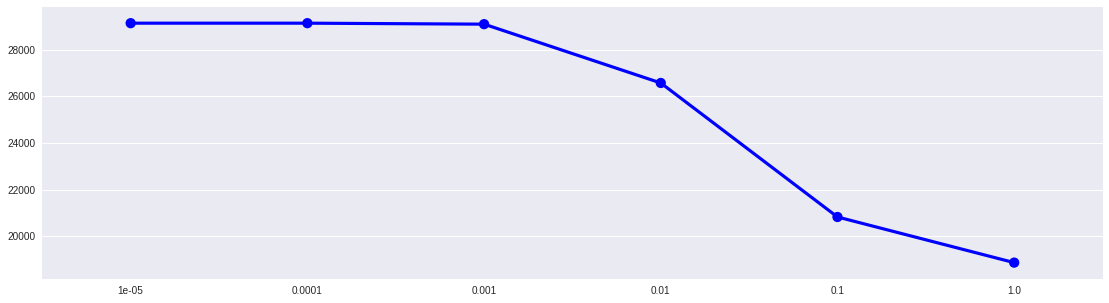

In [0]:
plt.figure(figsize = (19,5))
sns.pointplot(x = list(cv_no_zeros.keys()),y=list(cv_no_zeros.values()),color ='blue')

** Observation ** 
1. As C increase Lambda decreases. As Lambda Decreases the sparisity decreases. 
2. The phenomenon has be observed above.
3. There is highest recall of negative reivews at C = 0.001. But there is very slight difference in the recall when C = 0.01. 
4. These 2 values can be put to comparison to check other metrics and over fitting and underfitting phenomenon to find the better model. 

------
** MODEL COMPARISON ** 

** C = 0.001 ** 

In [0]:
l1_r = LogisticRegression(penalty = 'l1',C = 0.001,n_jobs = -1)
l1_r. fit(bow_train,y_train)
pred = l1_r.predict(bow_test)
print(classification_report(pred,y_test))
t_pred = l1_r.predict(bow_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))


             precision    recall  f1-score   support

          0       0.08      0.89      0.14       230
          1       1.00      0.88      0.93     19770

avg / total       0.99      0.88      0.92     20000

 
 Train Error : 10.801666666666666

 Test Error : 12.470000000000002


In [0]:
confusion_matrix(pred,y_test)

array([[  205,    25],
       [ 2469, 17301]])

** C = 0.01 ** 

In [0]:
l2_r = LogisticRegression(penalty = 'l1',C = 0.01,n_jobs = -1)
l2_r. fit(bow_train,y_train)
pred = l2_r.predict(bow_test)
print(classification_report(pred,y_test))
t_pred = l2_r.predict(bow_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))


             precision    recall  f1-score   support

          0       0.49      0.79      0.60      1636
          1       0.98      0.93      0.95     18364

avg / total       0.94      0.91      0.92     20000

 
 Train Error : 5.235000000000001

 Test Error : 8.550000000000002


In [0]:
confusion_matrix(pred,y_test)

array([[ 1300,   336],
       [ 1374, 16990]])

-----

** OBSERVATIONS ** 

1. Both the models are not much overfitting with respect to the difference of train and test error. But model with C = 0.01 is much more sensible in classifying points. 
2. Model with ** C = 0.01 has higher TNR and TPR rates and less FPR and FNR rates.  **
3. This is due to the fact that ** Model C= 0.001 has very low precison (0.08) i.e low F1 Score **
4. ** C = 0.01 has the upper edge.  ** 



** Non Zero Features ** 

In [0]:
f_imp = dict(zip(bow.vocabulary_,l2_r.coef_[0]))

In [0]:
non_zero= dict()
for i in list(f_imp.keys()):
  if f_imp[i] ==0:
    pass
  else:
    non_zero[i] = (f_imp[i])

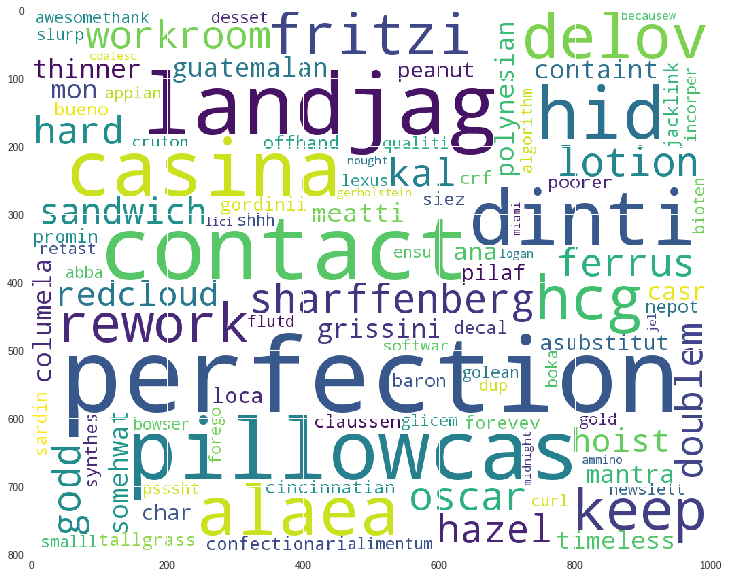

In [0]:
non_100 = {}
for i in sorted(non_zero.items(), key=operator.itemgetter(1),reverse= True)[:100]:
  non_100[i[0]] = i[1]
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(non_100))

<br>


## FEATURIZATION 2 : WORD 2 VEC


In [0]:
w2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_train.sav','rb'))
w2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_test.sav','rb'))

In [0]:
X_train = w2v_train.iloc[:,0:50].copy(deep=True)
X_test = w2v_test.iloc[:,0:50].copy(deep=True)
y_train = w2v_train['Score']
y_test = w2v_test['Score']

In [0]:
sc2 = StandardScaler()
X_train = sc2.fit_transform(X_train)
X_test = sc2.transform(X_test)

** Defining parameters grid for Grid search **

In [0]:
c_vals = []
for i in range(-4,2,1):
  c_vals.append(10**i)
  
param_grid = {'C':c_vals,'penalty':['l1','l2']}

In [0]:
clf = GridSearchCV(LogisticRegression(),param_grid,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   48.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=True)

In [0]:
clf.best_score_

0.8963812784594517

In [0]:
clf.best_params_

{'C': 10, 'penalty': 'l2'}

In [0]:
pred = clf.predict(X_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.40      0.72      0.52      2266
          1       0.98      0.91      0.94     27734

avg / total       0.93      0.90      0.91     30000

 
 Train Error : 9.125714285714281

 Test Error : 10.29


** Defining Parameters for Random Search CV ** 

1. Normal(mean = 0.1, STD = 0.01) :  C

In [0]:
param_dist= {'C':norm(loc=0.1,scale = 0.01),'penalty':['l1','l2']}

clf= RandomizedSearchCV(LogisticRegression(),param_dist,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8a8b07710>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_weighted', verbose=True)

In [0]:
clf.best_params_

{'C': 0.11331793202802784, 'penalty': 'l1'}

In [0]:
pred = clf.predict(X_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.40      0.72      0.51      2239
          1       0.98      0.91      0.94     27761

avg / total       0.93      0.90      0.91     30000

 
 Train Error : 9.11428571428572

 Test Error : 10.319999999999997


 ** Observation  : **
 
1. Both the models are not overfitting much in terms of the train and test difference of the errors. 
2. The recall and precision of the negative class reviews are similar for the both the models.
3. in Model 1 : L2 Regulariser with C = 10 has a greater  less Lambda and in comparison with Model 2 : L1 Regularise with C = 0.11. 
4. Considering the factors of regualrisation for future training  and in order to prevent the weight vectors in reaching towards infinity , the final model will be C = 0.113 and Penalty = "L1".


| C | ACCURACY   | RECALL : NEGATIVE REVIEWS |TRAIN ERROR | TEST ERROR | DIFFERENCE|
|------|------|-----|-----|----|----|
|   0.113 | 89.68% | 72 |9.114|10.32|1.206|


<br>

--------

## FEATURIZATION 3 : TF IDF WORD2VEC

In [0]:
tfw2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Train_TFW2V.sav','rb'))
tfw2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Test_TFW2V.sav','rb'))

In [0]:
X_train = tfw2v_train.iloc[:,0:50].copy(deep=True)
X_test = tfw2v_test.iloc[:,0:50].copy(deep=True)
y_train = tfw2v_train['Score']

y_test = tfw2v_test['Score']

** Standarad Scaling the Data ** 

In [0]:
sc3 = StandardScaler()
X_train = sc3.fit_transform(X_train)
X_test = sc3.transform(X_test)

** Defining the Alpha Range ** 

In [0]:
c_vals = []
for i in range(-4,2,1):
  c_vals.append(10**i)
  
param_grid = {'C':c_vals,'penalty':['l1','l2']}

 ** GRID SEARCH ** 

In [0]:
clf = GridSearchCV(LogisticRegression(),param_grid,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   43.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=True)

In [0]:
clf.best_score_

0.8813249349346663

In [0]:
clf.best_params_

{'C': 10, 'penalty': 'l1'}

In [0]:
pred = clf.predict(X_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.30      0.70      0.42      1745
          1       0.98      0.90      0.94     28255

avg / total       0.94      0.89      0.91     30000

 
 Train Error : 10.05285714285714

 Test Error : 11.339999999999995


In [0]:
confusion_matrix(pred,y_test)

array([[ 1222,   523],
       [ 2879, 25376]])

** RANDOM SEARCH ** 

In [0]:
param_dist= {'C':norm(loc=1,scale = 0.1),'penalty':['l1','l2']}

clf= RandomizedSearchCV(LogisticRegression(),param_dist,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f05a2c86e80>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_weighted', verbose=True)

In [0]:
clf.best_score_

0.8812694438518199

In [0]:
clf.best_params_

{'C': 1.115733396535734, 'penalty': 'l2'}

In [0]:
pred = clf.predict(X_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.30      0.70      0.42      1744
          1       0.98      0.90      0.94     28256

avg / total       0.94      0.89      0.91     30000

 
 Train Error : 10.050000000000004

 Test Error : 11.336666666666662


** Observations : **

1. Both of the model are given reasonbly the same acuracy, recall and precision where model M1 = (C = 10,penalty = L1) and model M2 = (C = 1.115 ,penalty = L2)
2. There is no much overfitting phenomenon happening even though for both word2vec representations the train and test error are high.
3.  The model with higher regularisation capability is chose again. 
4. **  M1 = C: 10 ,Penalty = L1 **


<br>

-------
## FEATURIZATION 4 : TF_IDF 


In [0]:
tf_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_tfidf.sav','rb'))
tf_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_tfidf.sav','rb'))
tf_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_tfidf.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
tfidf = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/tfidf.sav','rb'))

 Merging CV and Traing matrix for Cross validation in Grid Search

In [0]:
X_train = vstack([tf_train,tf_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

** Standard Scaling All the Data ** 

In [0]:
sc4 = StandardScaler(with_mean = False)
X_train = sc4.fit_transform(X_train) 
tf_test = sc4.transform(tf_test)

** Defining Lambda range  for L2 Regularizer : **

In [0]:
c_vals = []
for i in range(-4,4,1):
  c_vals.append(10**i)
  
param_grid = {'C':c_vals}

** GRID SEARCH  TO FIND THE BEST C VALUE  : L2 REGULARISATION ** 

In [0]:
clf = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=True)

In [0]:
clf.best_params_

{'C': 0.001}

In [0]:
pred = clf.predict(tf_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,Y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.55      0.72      0.62      2051
          1       0.97      0.93      0.95     17949

avg / total       0.92      0.91      0.92     20000

 
 Train Error : 2.7337500000000015

 Test Error : 8.955000000000002


** GRID SEARCH TO FIND THE BEST C VALUE : L1 Regularisation ** 

In [0]:
c_vals = []
for i in range(-2,2,1):
  c_vals.append(10**i)
  
param_grid = {'C':c_vals}

In [0]:
clf = GridSearchCV(LogisticRegression(penalty = 'l1'),param_grid,scoring = 'f1_weighted',n_jobs = -1,verbose = True)
clf.fit(X_train,Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=True)

In [0]:
clf.best_params_

{'C': 0.01}

In [0]:
pred = clf.predict(tf_test)
print(classification_report(pred,y_test))
t_pred = clf.predict(X_train)

print(" \n Train Error : " + str((1 -accuracy_score(t_pred,Y_train))*100))
print("\n Test Error : " + str((1-accuracy_score(pred,y_test))*100))

             precision    recall  f1-score   support

          0       0.56      0.81      0.66      1830
          1       0.98      0.93      0.96     18170

avg / total       0.94      0.92      0.93     20000

 
 Train Error : 4.883749999999997

 Test Error : 7.6300000000000034


** Observations : MODEL COMPARISON **

| C | ACCURACY   | RECALL : NEGATIVE REVIEWS |TRAIN ERROR | TEST ERROR | DIFFERENCE| PENALTY
|------|------|-----|-----|----|----|
|   0.01 | 93.37% | 81 |4.883|7.630|2.749| L1 |
|  0.001| 92.15% | 72|2.733 | 8.95| 6.217| L2 |

1. Clearly Model 1 with L1 regualarizer and with C = 0.01 has the better accuracy,recall of negative reviews and also less overfitting in comaprison to Model 2. 
2. The final model **M1 = C : 0.01 , Penalty = L1 **

______
** FEATURE IMPORTANCE ** 

In [0]:
#refiiting the model 
lmodel = LogisticRegression(C = 0.01,penalty = 'l1',n_jobs = -1)
lmodel.fit(X_train,Y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
lmodel.coef_[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
f_imp = dict(zip(tfidf.vocabulary_,lmodel.coef_[0]))

In [0]:
non_zero= dict()
for i in list(f_imp.keys()):
  if f_imp[i] ==0:
    pass
  else:
    non_zero[i] = (f_imp[i])

** Plotting Top 100 important features ** 

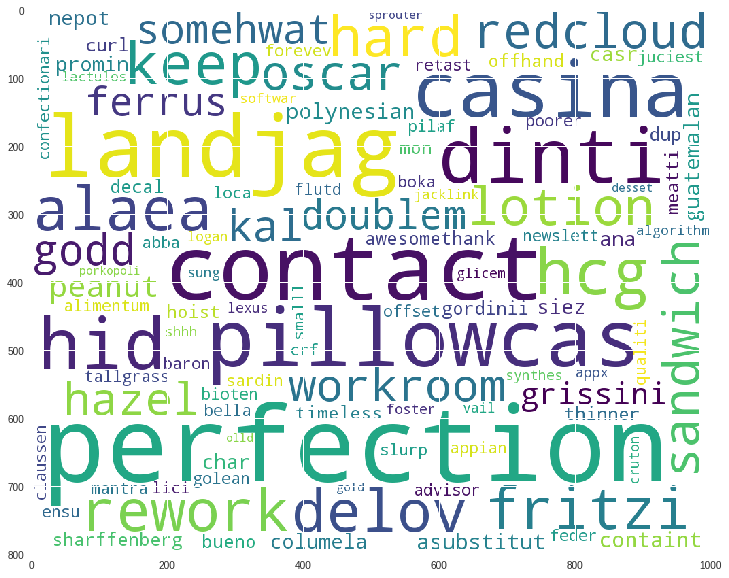

In [0]:
non_100 = {}
for i in sorted(non_zero.items(), key=operator.itemgetter(1),reverse= True)[:100]:
  non_100[i[0]] = i[1]
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(non_100))

<br>

------

### PERTUBATION TEST : MULTICOLLINEARITY CHECK : BAG OF WORDS REPRESENTATION 

In [0]:
bow_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_bow.sav','rb'))
bow_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_bow.sav','rb'))
bow_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_bow.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
bow = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/BOW.sav','rb'))

In [0]:
X_train = vstack([bow_train,bow_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

#standardizing the data

sc = StandardScaler(with_mean = False)
X_train = sc.fit_transform(X_train)

**1.  Fitting the Model with C = 0.01 for L2 Regularisation in order to avoid sparsity in Weight Vectors without adding Random Noise. **

In [14]:
l1 = LogisticRegression(penalty = 'l1',C = 0.01)
l1.fit(X_train,Y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
w1 = l1.coef_[0] #getting the feature importance without random noise in the data

** 2. Adding Random Noise to the data ** 

In [0]:
X_train = vstack([bow_train,bow_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)
X_train = X_train.astype(float)
X_train.data += np.random.normal(0,0.1) #adding random noise

sc = StandardScaler(with_mean = False)
X_train = sc.fit_transform(X_train)

** Refitting the data with noise  with the same dataset ** 

In [0]:
l2 = LogisticRegression(penalty = 'l1',C = 0.01)
l2.fit(X_train,Y_train)
w2 = l2.coef_[0]

In [0]:
delta_w = np.abs(((w1-w2)+0.0001)/(w1+0.0001))

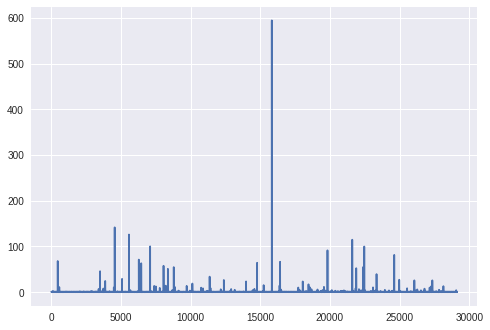

In [19]:
plt.plot(delta_w)

In [0]:
cy = np.cumsum(np.sort(delta_w))

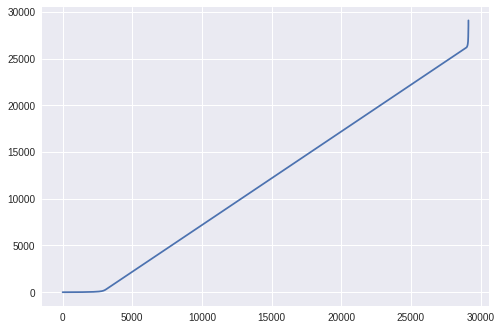

In [21]:
plt.plot(cy)

### Printing the Multi-collinear feautres

In [0]:
m_features = dict(zip(bow.vocabulary_,delta_w))

** Printing all the features whose weight changed more than 10% **

In [0]:
f_10 = {}

for i in sorted(m_features.items(), key=operator.itemgetter(1),reverse= True):
  if i[1]>10:
    f_10[i[0]] = i[1]

In [28]:
f_10

{'aficianado': 14.344952983081212,
 'appeci': 51.06359030868913,
 'arrabbiata': 66.60670443868705,
 'asid': 126.12845042585961,
 'aspirin': 24.573177567635074,
 'bacopa': 14.504796785291669,
 'bagger': 11.580387336400856,
 'bristol': 99.91089547392951,
 'britannia': 25.915054231285048,
 'carpet': 71.29878214813776,
 'characterist': 11.232301025497648,
 'clan': 23.50249921335904,
 'contretemp': 594.3775053868036,
 'dei': 12.635187528393718,
 'diarria': 55.40762504690514,
 'erythorb': 12.517585437212556,
 'fanta': 18.964531939258826,
 'fetal': 15.46165327872387,
 'flamingo': 17.211131273903625,
 'floss': 13.74890580114172,
 'francesco': 39.561316951783716,
 'getcha': 91.5697668935053,
 'grandaught': 64.32143773147479,
 'growt': 11.647399000453863,
 'gurlic': 57.73614465437743,
 'hall': 10.385162470868135,
 'hover': 100.2512323022687,
 'infloor': 23.56955436279787,
 'lincoln': 81.56369102096674,
 'lorenza': 52.51017425618982,
 'maneuv': 10.206415026842068,
 'monterari': 13.19153084737339,

## SUMMARY 

|FEATURIZATION| C | RECALL : NEGATIVE REVIEWS |TRAIN ERROR | TEST ERROR | DIFFERENCE| PENALTY
|------|------|-----|-----|----|----|
| BOW|   0.01 | 79 |5.23|8.55|3.32| L1 |
| TF IDF|  0.01 | 81|4.883 | 7.630| 2.749| L1 |
|AVG WORD2VEC |   0.113  | 72 |9.114|10.32|1.206| L1|
| TFIDF WORD2VEC|  10 | 70|10.05 | 11.333| 1.3| L1 |